In [1]:
# Descomente e rode para usar no colab
# ! pip install git+https://github.com/flaviovdf/musica.git

# Shazam do GTZAN

**Objetivos**
1. Entender o Shazam!

**Resultado Esperado**
1. Saber criar um índice de constelações
1. Realizar consultas no mesmo

**Caso queira indexar tudo, recomendo o uso da biblioteca sparse, descomente abaixo**

In [2]:
from μsica import μsf
from μsica import μsp

from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd

In [3]:
μsp.init_matplotlib()
plt.ion()

In [4]:
μsf.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/archive.zip',
             'archive.zip', False)
μsf.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/queryPublic_George.zip',
             'queryPublic_George.zip', False)

archive.zip: 1.21GB [02:24, 8.99MB/s]
queryPublic_George.zip: 723MB [01:57, 6.46MB/s] 


In [5]:
μsf.extract('archive.zip', '.')

In [6]:
μsf.extract('queryPublic_George.zip', '.')

In [7]:
! ls

 Data	      'mir-2013-GeorgeDataset_snippet(10sec)_1062'
 archive.zip   queryPublic_George.zip
 lab09.ipynb


## Introdução

Neste notebook vamos tentar montar um [Shazam](https://shazam.com). Criado em meados de 2003 \[[1](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)\], o Shazam é um serviço que identifica músicas com base em clipes pequenos. No começo dos anos 2010s, o advento de aplicativos de celulares popularizou o serviço Shazam. Com o passar dos anos, as ideias do Shazam foram copiadas por empresas como a Google a Apple, que incluem variações do serviço de descoberta nos seus sistemas operacionais Android e IOs. Se não me engano, a Apple usa APIs do Shazam, enquanto a Google tem sua versões própria.

![](https://digitalagencynetwork.com/wp-content/uploads/2017/12/confirmed-apple-bought-shazam-app-reasonable-point.jpg)

O funcionamento do Shazam é feito através da técnica de *audio fingerprinting*. Aqui, um índice invertido de atributos musicais é criado. Com tal índice, podemos rapidamente identificar uma música através de um clipe pequeno da mesma. A figura abaixo mostra a ideia de como um serviço seria implementado no mundo real. Aqui, vamos fazer uma versão simples em memória.

![Audio Finger](https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C7/FMP_C7_F02.png)

## Base de Dados

Para nossa tarefa, vamos fazer uso da base GTZAN. A base GTZAN é composta por 1.000 trechos de música e áudio de meio minuto, classificados individualmente em dez categorias. Por hora, vamos ignorar as categorias e focar apenas nas músicas. Para um melhor entendimento do GTZAN leia a referência \[[2](https://arxiv.org/pdf/1306.1461.pdf)\]. 

### A base de dados que será indexada (GTZAN)

Toda a base GTZAN pode ser encontrada no [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification). Caso necessite, uma versão também pode ser encontrada no drive junto deste notebook.

Abaixo mostramos as pastas e arquivos do GTZAN. Tais músicas vem no formato wav. Sua tarefa será montar um índice de um **subconjunto** de tais músicas. Já explico.

In [8]:
! ls Data/genres_original

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [9]:
! ls Data/genres_original/blues | head

blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav
blues.00005.wav
blues.00006.wav
blues.00007.wav
blues.00008.wav
blues.00009.wav


### A base de dados de consulta (MIREX-2020)

Como sua tarefa é montar um Shazam, precisamos de uma base de consultas. Desde 2005, a [Music Information Retrieval Evaluation eXchange (MIREX 2020)](https://www.music-ir.org/mirex) organia competições no tema de recuperação de informação musical. Já fazem alguns anos, desde 2013, onde anualmente uma das competições do MIREX é no tema de *audio fingerprinting* (nossa tarefa). O link ao lado contém a descrição da tarefa [Audio Fingerprinting MIREX 2020](https://www.music-ir.org/mirex/wiki/2020:Audio_Fingerprinting).

Para simular o uso do Shazam, junto com tal competição, uma base de dados de consultas é fornecida. Tal base foi gravada em telefones celulares em diferentes ambientes. Para entender o formato de tal base, segue uma lista dos arquivos.

In [10]:
! ls -l mir-2013-GeorgeDataset_snippet\(10sec\)_1062

total 921780
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 Classical.00074-snippet-10-0.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 Classical.00074-snippet-10-10.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 Classical.00074-snippet-10-20.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00000-snippet-10-0.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00000-snippet-10-10.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00000-snippet-10-20.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00003-snippet-10-0.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00003-snippet-10-10.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00003-snippet-10-20.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00004-snippet-10-0.wav
-rw-r--r-- 1 thiagopoppe thiagopoppe 884782 Jan 27 22:18 blues.00004-snippet-10-10.wav
-rw-r--r-- 1 thiagopop

Observe como cada arquivo corresponde a uma música do GTZAN. Além do mais, três clipes de 10 segundos são fornecidos por música. Por exemplos, a música `blues.00000.wav`do GTZAN tem como respostas os clipes: `blues.00000-snippet-10-0.wav`, `blues.00000-snippet-10-10.wav`, `blues.00000-snippet-10-20.wav`.

## Sua Tarefa

Sabendo das bases acima, sua tarefa será em indexar e mensurar a Precision@10 (fração de acertos na primeira posição retornada) das músicas acima. **Por questões de memória limitada, você pode indexar apenas as músicas de consulta, não precisa indexar todo GTZAN. Faça tudo na memória principal mesmo**.

Para realizar sua tarefa crie mapas de constetalação das músicas e da consulta.

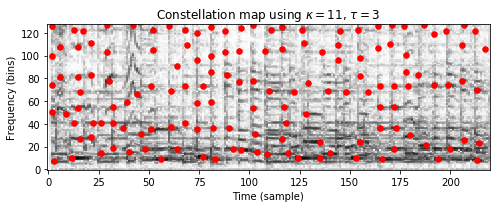

### *Importante*: Fourier no GTZAN

No GTZAN, cada música é gravada a uma taxa de amostragem de 22,05 kHz e arquivos de áudio mono de 16 bits no formato `.wav`. *Como toda música tem a mesma taxa de amostragem, os índices discretos da transformada de Fourier são os mesmos para todas as músicas. ELAS JÁ VEM BINARIZADAS NO EIXO-Y do mapa de constelação*.

## Carregando os Espectrogramas

O código abaixo carrega os espectrogramas. Coloquei também um função que plota os mesmos.

In [11]:
import warnings
warnings.filterwarnings('ignore')

def plot_spec(stft, sr, constelation=None):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
                                   y_axis='log',
                                   x_axis='time',
                                   hop_length=sr,
                                   ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    if constelation is not None and constelation.any():
        x, y = np.where(constelation.T)
        ax.scatter(x, y, s=100, alpha=0.6, edgecolor='k')
    fig.show()

**Observe como passo o `hop_length=sr` no stft**. Como estou com uma música com taxa SR por segundo, tiro a média a cada SR frames. Isso deixa meu espectrograma em SEGUNDOS. Algumas musicas passam um pouco de 30 segundos, portanto pego os trinta na marra.

In [12]:
def my_stft(wave, sr):
    stft_complex = librosa.stft(wave, hop_length=sr) # deve ter approx 30 secs
    stft = np.abs(stft_complex) # tira a norma do real e imag
    return stft[:, :30] # força 30 secs

(1025, 30)

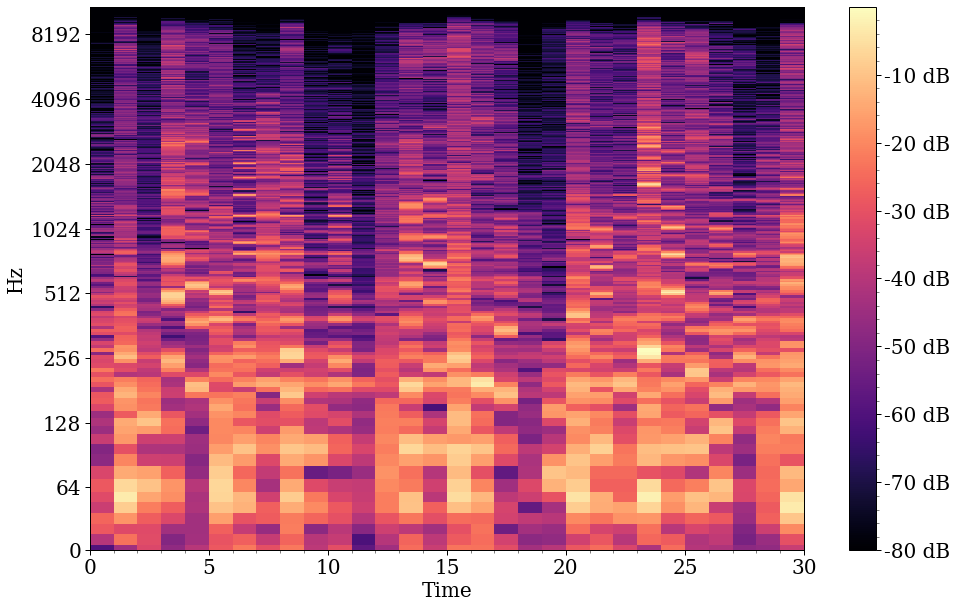

In [13]:
wave, sr = librosa.load('Data/genres_original/blues/blues.00001.wav',
                        mono=True)
stft = my_stft(wave, sr)
plot_spec(stft, sr)
stft.shape

### Mapa de Constelação

O mapa pode ser implementado com a chamada: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html. O `mode='constant'` faz um preenchimento nas bordas para garantir que tudo funcione. O `size` diz o tamanho do filtro que vamos usar.

In [14]:
from scipy import ndimage

def constellation_map(stft, kappa=7, tau=7, thresh=0.01):
    result = ndimage.maximum_filter(stft, size=[2*kappa+1, 2*tau+1],
                                    mode='constant')
    C = np.logical_and(stft == result, result > thresh)
    return C

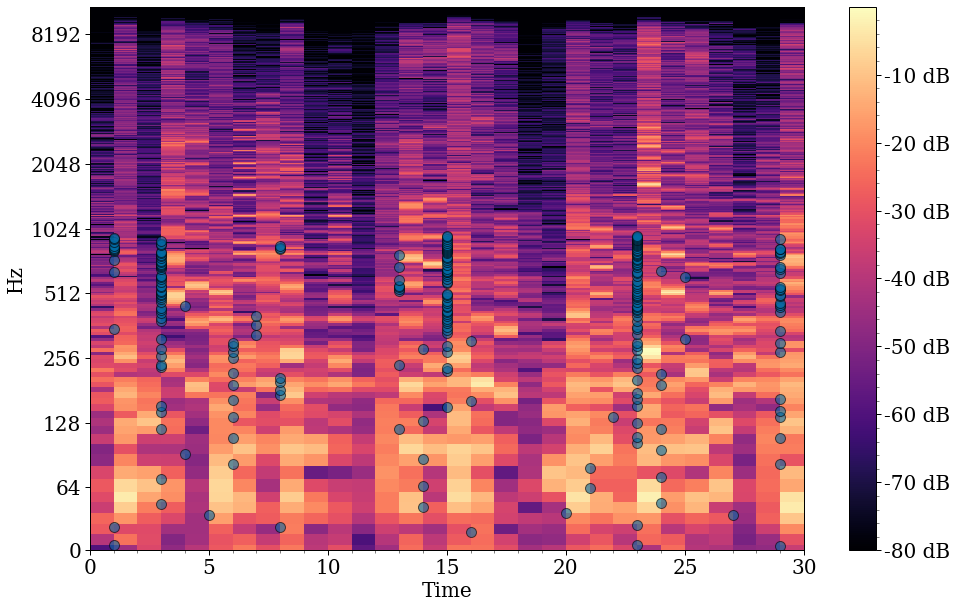

In [15]:
constelation = constellation_map(stft, kappa=5, tau=5)
plot_spec(stft, sr, constelation)

## Índice

Observe como cada consulta precisa ser comparada com todas as seções (tendo a mesma duração da consulta) de todas as músicas contidas no base de dados. Tal estratégia de busca exaustiva, cujo tempo de execução depende linearmente do número e do tamanho da base de dados, não é viável. Portanto você deve implementar um índice como visto em sala de aula. A função `match_query_gtzan` lhe ajuda a carregar apenas os arquivos que existem na base de consultas.

In [16]:
import glob
import os

def match_query_gtzan():
    rv = {}
    path = os.path.join('mir-2013-GeorgeDataset_snippet(10sec)_1062', '*.wav')
    for wav_fpath in glob.glob(path):
        file_name = os.path.basename(wav_fpath)
        file_name_gztan = '{}{}'.format(file_name.split('-')[0], '.wav')
        genre = file_name_gztan.split('.')[0]
        rv[wav_fpath] = os.path.join('Data', 'genres_original', genre,
                                     file_name_gztan)
    return rv
matches = match_query_gtzan()
print(list(matches.items())[:10])

[('mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00010-snippet-10-0.wav', 'Data/genres_original/jazz/jazz.00010.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/reggae.00025-snippet-10-10.wav', 'Data/genres_original/reggae/reggae.00025.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/disco.00069-snippet-10-10.wav', 'Data/genres_original/disco/disco.00069.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/hiphop.00045-snippet-10-20.wav', 'Data/genres_original/hiphop/hiphop.00045.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/rock.00025-snippet-10-20.wav', 'Data/genres_original/rock/rock.00025.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/pop.00084-snippet-10-10.wav', 'Data/genres_original/pop/pop.00084.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/rock.00069-snippet-10-20.wav', 'Data/genres_original/rock/rock.00069.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/pop.00065-snippet-10-10.wav', 'Data/genres_original/pop/pop.00065.wav'), ('mir-2013-GeorgeDatase

In [17]:
from collections import defaultdict

def index(colecao_de_stfts, kappa, tau):
    pass
        
index(matches.values(), kappa=5, tau=5)

In [18]:
index = defaultdict(lambda: defaultdict(list))
for row, col in zip(*np.where(constelation)):
    index[row][col].append('d')

## Problemas

1. Implemente o índice acima. É possível implementar o mesmo na memória. Use estruturas python ou uma matriz esparsa 3d (um tensor). Veja a descrição do lab. Da para fazer sem o sparse, mas não deve funcionar na base toda.
1. Realize as consultas e mensure o seu valor de precision@10
1. Qual o efeito do kappa e do tau no seu resultado?
1. Mude seu código para funciona na base toda (*extra*)

# Funções auxiliares

In [19]:
from collections import defaultdict

def delete_error_queries(queries):
    to_delete = []
    for query in queries:
        try:
            librosa.load(matches[query])
        except:
            print('Query {} will be deleted'.format(query))
            to_delete.append(query)
            
    for query in to_delete:
        del queries[query]
        
    return queries

def create_index(songs, kappa, tau):
    index = defaultdict(lambda: defaultdict(list))
    for song in songs:
        wave, sr = librosa.load(song, mono=True)
        constellation = constellation_map(my_stft(wave, sr), kappa=kappa, tau=tau)
        
        # Inserindo a música no índice (frequência, tempo) onde a constelação é True
        for f, t in zip(*np.where(constellation)):
            index[f][t].append(song)
        
    return index

def make_query(song, index, kappa, tau):
    # Extraindo a constelação da música de entrada
    wave, sr = librosa.load(song, mono=True)
    constellation = constellation_map(my_stft(wave, sr), kappa=kappa, tau=tau)
    
    # Counter será uma estrutura auxiliar para mantermos a proximidade de cada documento (doc -> shift -> value)
    counter = defaultdict(lambda: defaultdict(int))
    
    for f, t in zip(*np.where(constellation)):
        for item in index[f].items():
            shift = item[0] - t
            for doc in item[1]:
                counter[doc][shift] += 1
    
    # Obtendo o "valor de proximidade" para cada documento
    docs_values = defaultdict(int)
    for doc in counter:
        for shift in counter[doc]:
            docs_values[doc] = max(docs_values[doc], counter[doc][shift])
    
    # Ordenando a lista de documentos baseado no seu valor e retornando
    sorted_docs = sorted(list(docs_values.items()), key=lambda p: p[1])[::-1]
    return list(map(lambda p: p[0], sorted_docs))

# Houve uma mudança no enunciado em uma das aulas.
# Agora devemos realizar o cálculo 1/(posição+1) da resposta e tirar a média.
def compute_answer_posititions(songs, matches, kappa, tau):
    positions = []
    index = create_index(songs, kappa, tau)
    
    for item in matches.items():
        answer = make_query(item[0], index, kappa, tau)
        positions.append(answer.index(item[1]))
        
    positions = np.array(positions)
    return 1 + positions

# Questão 01)
- Implemente o índice acima. É possível implementar o mesmo na memória. Use estruturas python ou uma matriz esparsa 3d (um tensor). Veja a descrição do lab. Da para fazer sem o sparse, mas não deve funcionar na base toda.

In [20]:
# Lendo os dados de consulta
matches = match_query_gtzan()
print("Number of queries:", len(matches))

Number of queries: 1062


In [21]:
# Limpando dados que resultam em algum erro ao serem lidos pelo librosa (não são encontrados ou estão corrompidos)
matches = delete_error_queries(matches)
print("Number of queries:", len(matches))

Query mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00054-snippet-10-20.wav will be deleted
Query mir-2013-GeorgeDataset_snippet(10sec)_1062/Classical.00074-snippet-10-0.wav will be deleted
Query mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00054-snippet-10-10.wav will be deleted
Query mir-2013-GeorgeDataset_snippet(10sec)_1062/Classical.00074-snippet-10-20.wav will be deleted
Query mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00054-snippet-10-0.wav will be deleted
Query mir-2013-GeorgeDataset_snippet(10sec)_1062/Classical.00074-snippet-10-10.wav will be deleted
Number of queries: 1056


In [22]:
# Irei fazer o índice apenas com os dados da consulta
# Criando nosso índice e olhando a primeira posição
songs = set(matches.values())
index = create_index(songs, kappa=5, tau=5)

print("Índice com f_idx = 0:")
index[0]

Índice com f_idx = 0:


defaultdict(list,
            {0: ['Data/genres_original/metal/metal.00044.wav',
              'Data/genres_original/jazz/jazz.00070.wav',
              'Data/genres_original/rock/rock.00070.wav',
              'Data/genres_original/classical/classical.00065.wav',
              'Data/genres_original/country/country.00024.wav',
              'Data/genres_original/metal/metal.00065.wav',
              'Data/genres_original/blues/blues.00009.wav',
              'Data/genres_original/reggae/reggae.00040.wav',
              'Data/genres_original/rock/rock.00069.wav',
              'Data/genres_original/classical/classical.00054.wav',
              'Data/genres_original/disco/disco.00069.wav',
              'Data/genres_original/rock/rock.00054.wav',
              'Data/genres_original/blues/blues.00049.wav',
              'Data/genres_original/jazz/jazz.00044.wav'],
             29: ['Data/genres_original/jazz/jazz.00070.wav',
              'Data/genres_original/rock/rock.00070.wav',
      

# Questão 02)
- Realize as consultas e mensure o seu valor de precision@10.

In [23]:
# Exemplo de uma consulta
song, correct = list(matches.items())[0]
answer = make_query(song, index, kappa=4, tau=4)

print("Música de entrada:", song)
print("Resposta correta:", correct)
print("Posição da resposta correta:", answer.index(correct) + 1)

Música de entrada: mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00010-snippet-10-0.wav
Resposta correta: Data/genres_original/jazz/jazz.00010.wav
Posição da resposta correta: 1


In [24]:
%%time

# Houve uma mudança no enunciado em uma das aulas.
# Agora devemos realizar o cálculo (1/posição) da resposta e tirar a média.
positions = compute_answer_posititions(songs, matches, kappa=4, tau=4)
precision = np.mean(1 / positions)

print("Precisão:", np.round(precision, decimals=5))

Precisão: 0.13097
CPU times: user 7min, sys: 0 ns, total: 7min
Wall time: 7min


# Questão 03)
- Qual o efeito do kappa e do tau no seu resultado?

In [25]:
results = []
for kappa, tau in [(2, 8), (4, 4), (8, 2)]:
    positions = compute_answer_posititions(songs, matches, kappa=kappa, tau=tau)
    precision = np.mean(1 / positions)

    results.append([
        kappa,
        tau,
        np.round(precision, decimals=5), # precisão média
        positions[positions == 1].shape[0], # número de músicas top1
        positions[positions <= 5].shape[0], # número de músicas dentre os top5
        positions[positions <= 10].shape[0] # número de músicas dentre os top10
    ])
    
pd.DataFrame(results, columns=["kappa", "tau", "precision_mean", "top1", "top5", "top10"])

,kappa,tau,precision_mean,top1,top5,top10
0,2,8,0.09361,68,110,146
1,4,4,0.13097,101,160,200
2,8,2,0.17154,136,204,255


- **Obs.:** na tabela acima, as colunas top1, top5 e top10 são referentes à quantidade de músicas onde as respostas foram retornadas na primeira posição, dentre as 5 primeiras posições e dentre as 10 primeiras posições, respectivamente.

- Como podemos observar acima, ao escolhermos um valor maior para $\kappa$ (kappa) e menor para $\tau$ (tau) obtemos um resultado melhor. Isso pode ser justificado, provavelmente, por conta de estarmos trabalhando com áudios de 10 segundos (consultas) e 30 segundos (dados). Como o valor de $\tau$ reflete quantos pontos iremos "pegar" na horizontal (tempo) para construirmos a constelação utilizada pelo índice, ao escolhermos um valor menor, estaremos possibilitando a extração de mais características temporais do nosso espectograma. Em contrapartida, como temos um *range* maior de frequências, aumentar o valor de $\kappa$ pode potencialmente melhorar a nossa resposta. De modo geral, para os valores testados acima, a escolha $(\kappa = 8, \tau = 2)$ resultaram na melhor precisão média, e consequentemente, no melhor top1, top5 e top10.

# Questão 04)
- Mude seu código para funcionar na base toda (extra).

In [26]:
import glob

# Lendo toda a base e removendo .wav que geram um erro ao darmos load
wav_files = sorted(glob.glob("Data/genres_original/**/*.wav"))
print("Número total de .wav:", len(wav_files))

data = []
for file in wav_files:
    try:
        librosa.load(file)
        data.append(file)
    except:
        pass
    
print("Número de dados final:", len(data))

Número total de .wav: 1000
Número de dados final: 999


In [27]:
results = []
for kappa, tau in [(2, 8), (4, 4), (8, 2)]:
    positions = compute_answer_posititions(data, matches, kappa=kappa, tau=tau)
    precision = np.mean(1 / positions)

    results.append([
        kappa,
        tau,
        np.round(precision, decimals=5), # precisão média
        positions[positions == 1].shape[0], # número de músicas top1
        positions[positions <= 5].shape[0], # número de músicas dentre os top5
        positions[positions <= 10].shape[0] # número de músicas dentre os top10
    ])
    
pd.DataFrame(results, columns=["kappa", "tau", "precision_mean", "top1", "top5", "top10"])

,kappa,tau,precision_mean,top1,top5,top10
0,2,8,0.06986,53,85,104
1,4,4,0.09692,71,123,151
2,8,2,0.13073,102,165,196


- Podemos perceber que ao utilizarmos a base completa, obtemos resultados significativamente piores do que quando utilizamos um conjunto seleto dos dados. Porém, ainda percebemos o mesmo comportamento descrito anteriormente quanto aos parâmetros $\kappa$ e $\tau$.